### Baseline Model - Duration Excluded

Solution currently used by the bank

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

In [2]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, validation_curve, learning_curve
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format

In [3]:
os.listdir('../data/pickle_files')

['df_pickle_w_all_stats', 'df_pickle', 'df_pickle_w_time_stats']

In [4]:
#Loading df1:
df = pd.read_pickle('../data/pickle_files/df_pickle')

In [5]:
#Excluding the duration variable as it cannot be used in our baseline
df = df.drop(columns = ['duration'])

In [6]:
def scale_noncat_only(df):
    X_temp_noncat = df.select_dtypes(exclude=['int8'])
    X_temp_cat = df.select_dtypes(include=['int8'])
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = scaler.transform(X_temp_noncat)
    X = pd.concat([pd.DataFrame(X_transformed, columns =X_temp_noncat.columns), X_temp_cat], axis = 1)
    X = X.drop(columns=['y'])
    y = df['y']
    #will work with numpy arrays
    y = np.array(y)
    X = np.array(X)
    
    return X, y

X, y = scale_noncat_only(df)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [7]:
#Checking dtypes have loaded correctly (should return empty index)
df.select_dtypes(exclude = ['float64', 'int64', 'int8']).columns

Index([], dtype='object')

In [8]:
X.shape

(41188, 19)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, random_state = 4)

In [10]:
for n in [1, 5, 20]:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    print("K Neighbors Classifier = {:.6f}".format(n))
    print("Training Accuracy: {}".format(clf.score(X_train, y_train)))
    print("Test Accuracy: {}".format(clf.score(X_test, y_test)))
    print("----")

K Neighbors Classifier = 1.000000
Training Accuracy: 0.9951442167621637
Test Accuracy: 0.848013984655725
----
K Neighbors Classifier = 5.000000
Training Accuracy: 0.9135346864782623
Test Accuracy: 0.8865689035641449
----
K Neighbors Classifier = 20.000000
Training Accuracy: 0.9019131785957075
Test Accuracy: 0.8974458580168981
----


Baseline model with Cross Validation

In [11]:
#the classifier with 20 neighbors seems to be better as lower values seem to overfit
#it's too early to tell anyways, but this gives us a starting point
#we will pick the best hyperparameters later with GridSearchCV
clf = KNeighborsClassifier(n_neighbors = 20).fit(X_train, y_train)

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy Mean and Standard Deviation on Test Set: %.3f, %.3f" %(np.mean(scores), np.std(scores)))

Accuracy Mean and Standard Deviation on Test Set: 0.897, 0.002


In [12]:
def print_scores(clf, X_test):
    y_pred = clf.predict(X_test)
    print("Scores on Test Dataset")
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Precision Score: ", precision_score(y_test, y_pred))

In [13]:
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

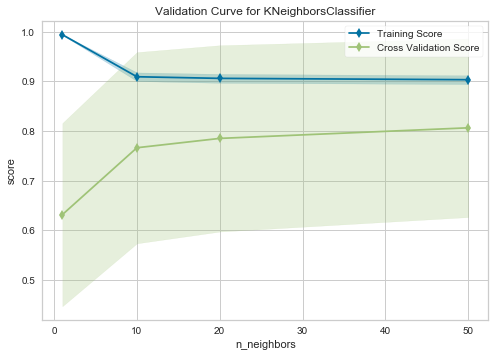

In [14]:
viz = ValidationCurve(
    clf, param_name="n_neighbors",
    param_range=[1,10,20,50], cv=10, scoring="accuracy"
)
# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

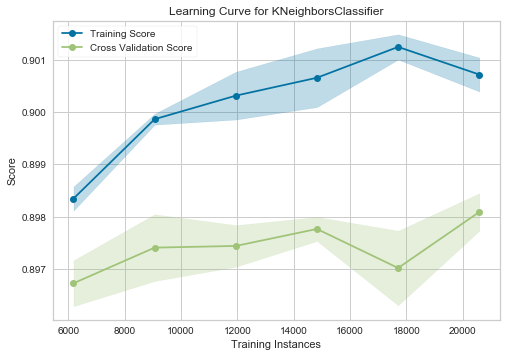

In [15]:
viz = LearningCurve(
    clf, cv=3, train_sizes=np.linspace(0.3, 1.0, 6),
    scoring='accuracy', n_jobs=4)
viz.fit(X_train, y_train)
viz.poof()

##### Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances. 

##### Recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.

Precision can be seen as a measure of exactness or quality, whereas recall is a measure of completeness or quantity.

Precision = TP/(TP+FP) ---- Recall = TP/(TP+FN)

While accuracy seems high, we have quite a lot of false negatives i.e. labels we have misclassified as negative leading to a potential loss in revenue.
We need higher recall, which might come at the cost of having lower precision but that's ok - we'd rather detect more real customers even if that means overguessing at times

In [16]:
def make_conf_matrix(clf, X_test):
    y_pred = clf.predict(X_test)
    cmx = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index = ['No', 'Yes'],
                   columns = ['No', 'Yes'])
    return cmx

In [17]:
def plot_conf_matrix(cmx):
    cmap = mpl.colors.ListedColormap(['green'])
    cmap1 = mpl.colors.ListedColormap(['red'])
    mask1 = (cmx.isin([cmx.iloc[0,0],cmx.iloc[1,1]]))
    
    f, ax = plt.subplots(figsize = (9,6))
    sns.heatmap(cmx, annot=True, fmt = 'g', cmap = cmap,
            cbar = False, annot_kws={"size": 20},
            ax=ax)
    sns.heatmap(cmx, mask=mask1 , cmap=cmap1, cbar=False)

    ax.set_ylabel('True label', fontsize = 15)
    ax.set_xlabel('Predicted label', fontsize = 15)
    ax.set_title("Confusion Matrix", fontsize = 20)
    plt.show()

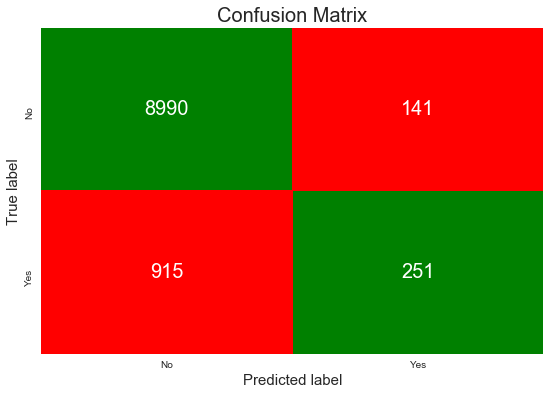

In [18]:
#Creating Confusion Matrix for Dirty Model:
cmx = make_conf_matrix(clf, X_test)
plot_conf_matrix(cmx)

In [19]:
#Sanity Check - verifying results 
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)
#the results are correct

8990 141 915 251


##### We have 703 false negatives. This means we have 703 customers we are misclassifying as uninterested! In comparison with only 463 customers who are correctly classified as interested for a total of 1166 True Positives (sum across second row). We must try to move customers from the bottom left to the bottom right quadrants

We want to increase the True Positive Rate = True Positives / (True Positives + False Negatives)
The true positive rate is known as Recall or Sensitivity.

In [20]:
y_pred = clf.predict_proba(X_test)

In [21]:
pd.DataFrame(y_pred).head()

,0,1
0,0.90,0.10
1,0.95,0.05
2,0.95,0.05
3,0.90,0.10
4,1.00,0.00


In [22]:
#pd.DataFrame(y_pred).T.plot(kind='scatter')

In [23]:
from yellowbrick.classifier import ROCAUC

In [24]:
classes = ['subscription', 'no subscription']

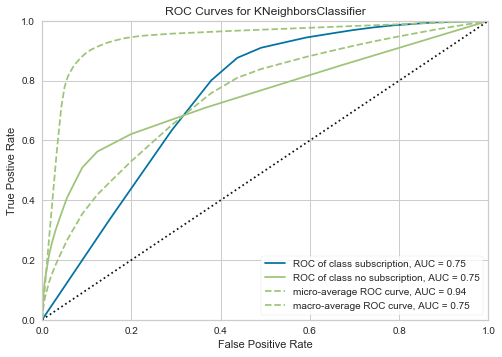

In [25]:
visualizer = ROCAUC(clf, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

The Receiver Operating Characteristic (ROC) is a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the model’s sensitivity and specificity. When plotted, a ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

This leads to another metric, area under the curve (AUC), which is a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is. However, it is also important to inspect the “steepness” of the curve, as this describes the maximization of the true positive rate while minimizing the false positive rate.

In [26]:
def plot_precision_recall(clf, X_test):
    
    y_pred = clf.predict(X_test)
    
    p = np.linspace(10,100,len(y_pred))
    
    precision, recall, thresholds = precision_recall_curve(y_test, probas_pred=p)
    average_precision = average_precision_score(y_test, y_pred)
    
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

Average precision-recall score: 0.23


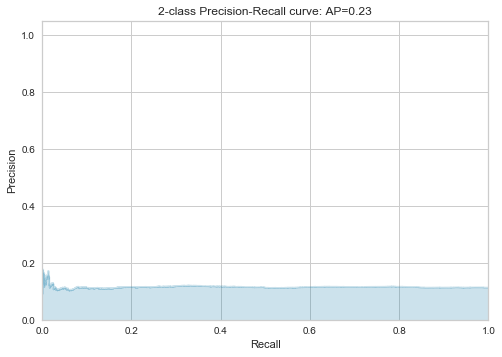

In [27]:
plot_precision_recall(clf, X_test)

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:
where  and  are the precision and recall at the nth threshold

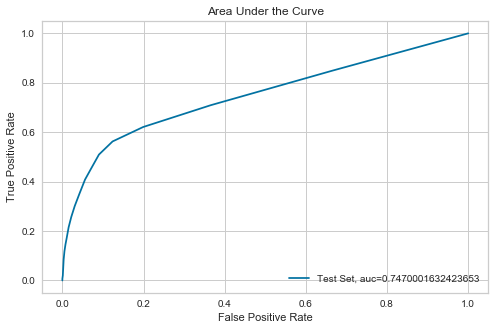

In [28]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize = (8,5))
plt.plot(fpr,tpr,label="Test Set, auc="+str(auc))
plt.title("Area Under the Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.show()

In [29]:
#StratifiedKFold is a variation of k-fold which returns stratified folds: 
#each set contains approximately the same percentage 
#of samples of each target class as the complete set.
skf = StratifiedKFold(n_splits=5, random_state = 0)
scores = []

In [30]:
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

In [31]:
def print_foldscore(X, y, kfold_obj, n):
    
    for k, (train, test) in enumerate(kfold_obj.split(X, y)):
        clf = KNeighborsClassifier(n_neighbors = n)
        clf.fit(X.iloc[train], y.iloc[train])
        print("[fold {0}] N Neighbors: {1:.5f}, CV score: {2:.5f}".format(k, clf.n_neighbors, clf.score(X.iloc[test], y.iloc[test])))
        scores.append(clf.score(X.iloc[test], y.iloc[test]))

In [32]:
for n in [i**2 for i in range(4,7)]:
    print("Value for n parameter: ", n)
    print_foldscore(X_train, y_train, skf, n)
    print("----")

Value for n parameter:  16
[fold 0] N Neighbors: 16.00000, CV score: 0.89885
[fold 1] N Neighbors: 16.00000, CV score: 0.89756
[fold 2] N Neighbors: 16.00000, CV score: 0.89738
[fold 3] N Neighbors: 16.00000, CV score: 0.89786
[fold 4] N Neighbors: 16.00000, CV score: 0.89542
----
Value for n parameter:  25
[fold 0] N Neighbors: 25.00000, CV score: 0.90015
[fold 1] N Neighbors: 25.00000, CV score: 0.89675
[fold 2] N Neighbors: 25.00000, CV score: 0.89641
[fold 3] N Neighbors: 25.00000, CV score: 0.89705
[fold 4] N Neighbors: 25.00000, CV score: 0.89607
----
Value for n parameter:  36
[fold 0] N Neighbors: 36.00000, CV score: 0.89966
[fold 1] N Neighbors: 36.00000, CV score: 0.89901
[fold 2] N Neighbors: 36.00000, CV score: 0.89624
[fold 3] N Neighbors: 36.00000, CV score: 0.89770
[fold 4] N Neighbors: 36.00000, CV score: 0.89849
----


#### Hyperparameter Tuning

In [33]:
clf = KNeighborsClassifier()

In [34]:
def search_hyper(parameters, clf):
    gs = GridSearchCV(clf, parameters, cv = 3).fit(X_train, y_train)
    print('Best Estimator: ')
    gs.best_estimator_
    print('----')
    print_scores(gs.best_estimator_, X_test)
    return gs.best_estimator_

In [35]:
parameters_1 = {'n_neighbors':[15,20,25,30],
              'weights':['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree'], 
              'p': [1,2,3]}

In [36]:
parameters_2 = {'n_neighbors':[15,20,25,30],
              'weights':['uniform', 'distance'],
              'algorithm': ['auto'], 
              'p': [1,2,3],
              'metric':['manhattan', 'euclidean', 'mahalanobis']}

In [37]:
parameters_3 = {'n_neighbors':[20,25],
              'weights':['uniform', 'distance'],
              'algorithm': ['ball_tree'], 
              'p': [1,2,3],
              'metric':['manhattan', 'euclidean', 'mahalanobis']}

In [38]:
clf.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [ ]:
search_hyper(parameters_1, clf)

In [ ]:
search_hyper(parameters_2, clf)

In [ ]:
search_hyper(parameters_3, clf)

In [ ]:
best_clf = search_hyper(parameters_2, clf)
plot_precision_recall(best_clf, X_test)

Balanced classes are definitely helping out a lot! Let's continue with different parameters

Let's try the best parameters combination so far

In [ ]:
cmx = make_conf_matrix(best_clf, X_test)
plot_conf_matrix(cmx)

We have managed to greatly improve our recall, but the accuracy is nearly unchanged

In [ ]:
pred_proba_df = pd.DataFrame(best_clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

In [ ]:
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    
    test_accuracy = accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Accuracy is {}'.format(test_accuracy))

    test_recall = recall_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Recall Score is {}'.format(test_recall))

    test_precision = precision_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our Test Set Precision Score is {}'.format(test_precision))
    
    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
        Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))